In [1]:
pip install -r ../requirements.txt

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not open requirements file: [Errno 2] No such file or directory: '../requirements.txt'


In [2]:
import pandas as pd
from transformers import AutoModelForSequenceClassification
import numpy as np
import evaluate
from transformers import TrainingArguments, Trainer,AutoTokenizer
import torch
from torch.utils.data import Dataset
from sklearn.metrics import roc_auc_score,roc_curve, auc,f1_score
from sklearn.model_selection import train_test_split
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

In [3]:
model = AutoModelForSequenceClassification.from_pretrained("voidism/diffcse-bert-base-uncased-trans", num_labels=1)
metric = evaluate.load("accuracy")
training_args = TrainingArguments(output_dir="test_trainer", evaluation_strategy="epoch")

Some weights of the model checkpoint at voidism/diffcse-bert-base-uncased-trans were not used when initializing BertForSequenceClassification: ['aux_bert.encoder.layer.11.attention.output.dense.bias', 'lm_head.transform.dense.weight', 'aux_bert.encoder.layer.8.attention.output.dense.bias', 'aux_bert.encoder.layer.10.attention.self.value.bias', 'aux_bert.encoder.layer.1.attention.self.query.bias', 'aux_bert.encoder.layer.3.output.LayerNorm.bias', 'aux_bert.encoder.layer.10.attention.self.value.weight', 'generator.distilbert.transformer.layer.5.attention.k_lin.bias', 'aux_bert.encoder.layer.0.attention.self.query.weight', 'generator.vocab_projector.bias', 'aux_bert.encoder.layer.0.attention.self.key.bias', 'aux_bert.encoder.layer.1.attention.self.key.weight', 'aux_bert.encoder.layer.7.attention.self.query.weight', 'aux_bert.encoder.layer.9.attention.self.key.weight', 'generator.distilbert.transformer.layer.4.attention.q_lin.weight', 'aux_bert.embeddings.token_type_embeddings.weight', 'au

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at voidism/diffcse-bert-base-uncased-trans and are newly initialized: ['classifier.bias', 'bert.pooler.dense.weight', 'classifier.weight', 'bert.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [4]:
dataset_test = pd.read_parquet(r'val_rus.parquet', engine='fastparquet')
dataset_test

,text,label
0,В связи с этим в подпрограмму включены следующ...,1
1,В последнее время я её нечасто видел.,1
2,"Лермонтов прибыл на Кавказ, чтобы задействоват...",0
3,Хотите фруктового сока?,1
4,"Однако, в рамках существующих условий «...",0
...,...,...
21506,"Нет, не я, а ты!",1
21507,"Кинолента ""Бегущий По Огню"" названа лучшей фил...",0
21508,В настоящее время в городе работает более 200 ...,0
21509,Российская теннисистка Мария Вавринка рассказа...,0


In [5]:
dataset_train = pd.read_parquet(r'train_rus.parquet', engine='fastparquet')
dataset_train

,text,label
0,"Обустройство тротуаров, мостовых (в том числе ...",1
1,Въ издержкахъ же оныхъ вы имете присылать счет...,1
2,"Положи это туда, откуда взял.",1
3,Минстрой обозначил способы снижения энергоемко...,0
4,В конце 1873 года военный суд вынес решение по...,0
...,...,...
129061,Убытки МУП &quot;Теплоэнерго&nbsp;&ndash;. На ...,0
129062,Три сестры были молодёжными послами на Национа...,1
129063,В Прекрасной России Будущего коты создадут сво...,1
129064,В семье наше будущее!,0


In [ ]:
dataset_test['label'] = dataset_test['label'].astype(float)
dataset_train['label'] = dataset_train['label'].astype(float)

In [7]:
dataset_train, dataset_eval, _, _ = train_test_split(dataset_train, dataset_train, test_size = 0.25,
                                                      shuffle = True, random_state = 42)


Для русского датасета нужна загрузка его валидационной выборки

In [8]:
train_texts, train_labels = dataset_train['text'].tolist(),dataset_train['label'].tolist()
test_texts, test_labels = dataset_test['text'].tolist(),dataset_test['label'].tolist()
eval_texts, eval_labels = dataset_eval['text'].tolist(),dataset_eval['label'].tolist()

In [9]:
tokenizer = AutoTokenizer.from_pretrained("voidism/diffcse-bert-base-uncased-trans")
train_encodings = tokenizer(train_texts, return_tensors='pt',
                padding='max_length',
                max_length=512,
                truncation=True)
test_encodings = tokenizer(test_texts, return_tensors='pt',
                padding='max_length',
                max_length=512,
                truncation=True)
eval_encodings = tokenizer(eval_texts, return_tensors='pt',
                padding='max_length',
                max_length=512,
                truncation=True)

In [11]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [12]:
train_dataset = MyDataset(train_encodings, train_labels)
test_dataset = MyDataset(test_encodings, test_labels)
eval_dataset = MyDataset(eval_encodings, eval_labels)


In [13]:
optim_param = ['adafactor','adamw_torch']

In [14]:
trainer = []
result = []
final_lst = []
for opt in optim_param:
    training_args.optim = opt
    trainer += [Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=eval_dataset
    )]
for i in range(len(trainer)):
    trainer[i].train()
    lst = []
    result_test_pred = trainer[i].predict(eval_dataset)
    for i in range(len(eval_dataset.labels)):
        lst+=[scipy.special.expit(result_test_pred[0][i][0])]
    final_lst+=[lst]
    result += [pd.DataFrame(zip(eval_dataset.labels,lst),columns = ['true','pred'])]

***** Running training *****
  Num examples = 30
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 12
  Number of trainable parameters = 109483778
C:\Users\Nikita\AppData\Local\Temp\ipykernel_10124\3135598630.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Epoch,Training Loss,Validation Loss
1,No log,0.818323
2,No log,0.789432
3,No log,0.756015


***** Running Evaluation *****
  Num examples = 10
  Batch size = 8
***** Running Evaluation *****
  Num examples = 10
  Batch size = 8
***** Running Evaluation *****
  Num examples = 10
  Batch size = 8


Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Prediction *****
  Num examples = 10
  Batch size = 8


***** Running training *****
  Num examples = 30
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 12
  Number of trainable parameters = 109483778
C:\Users\Nikita\AppData\Local\Temp\ipykernel_10124\3135598630.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Epoch,Training Loss,Validation Loss
1,No log,0.783475
2,No log,0.767124
3,No log,0.785296


***** Running Evaluation *****
  Num examples = 10
  Batch size = 8
***** Running Evaluation *****
  Num examples = 10
  Batch size = 8
***** Running Evaluation *****
  Num examples = 10
  Batch size = 8


Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Prediction *****
  Num examples = 10
  Batch size = 8


In [15]:
res = []
for i in range(len(result)):
    res+=[roc_auc_score(result[i]['true'], result[i]['pred'])]
max_value = max(res)
max_index = res.index(max_value)
max_index

0

In [18]:
def find_model(optim_list,max_index):
    i = 0
    best_model = []
    for num_1,opt in enumerate(optim_list):
        print(i,opt)
        if i == max_index:
            best_model= [opt]
            return best_model
        else:
            i+=1
        

In [19]:
best_model = find_model(optim_param,max_index)
best_model

0 adafactor


['adafactor']

In [20]:
result_test_pred = trainer[max_index].predict(test_dataset)

***** Running Prediction *****
  Num examples = 10
  Batch size = 8
C:\Users\Nikita\AppData\Local\Temp\ipykernel_10124\3135598630.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


In [21]:
lst = []
for i in range(len(test_dataset.labels)):
    lst+=[scipy.special.expit(result_test_pred[0][i][0])]
final_res = pd.DataFrame(zip(test_dataset.labels,lst),columns = ['true','pred'])
final_res

,true,pred
0,0,0.416468
1,0,0.426478
2,1,0.368305
3,1,0.376901
4,0,0.405139
5,0,0.406762
6,0,0.377682
7,1,0.414561
8,1,0.413636
9,1,0.405412


In [22]:
def roc(test_result_old):   
    fpr, tpr, treshold = roc_curve(test_result_old['true'], test_result_old['pred'])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr,
         label=f'ROC (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Совмещенные ROC-кривые')
    plt.legend(loc="lower right")
    plt.show()

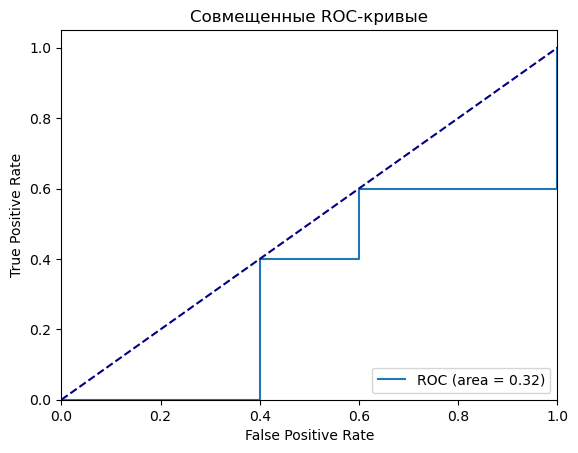

In [23]:
roc(final_res)

In [24]:
def confuns_matrix(train_rezalt_old):
    print(f'f1')
    print(f1_score(train_rezalt_old['true'].tolist(), [int(p>0.5) for p in train_rezalt_old['pred']], average='macro'))
    sns.heatmap(metrics.confusion_matrix(train_rezalt_old['true'],[int(p>0.5) for p in train_rezalt_old['pred']]),annot=True,cmap="Blues",square=True)
    plt.ylabel("label")
    plt.xlabel(f"")
    plt.title(f"Confusion matrix")
    plt.show()

f1
0.3333333333333333


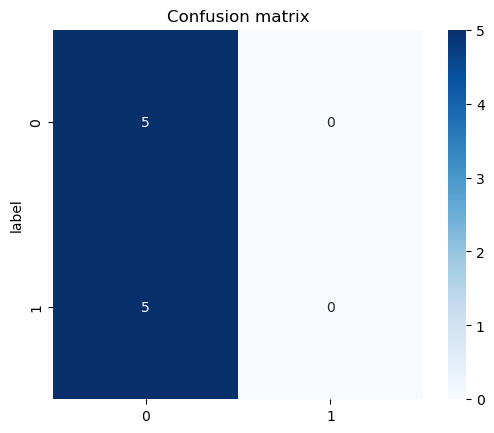

In [25]:
confuns_matrix(final_res)